# 볼린저 밴드
1. 파일 로드
2. 결측치와 이상치를 제거
3. 시간, 종가만의 데이터프레임을 생성
4. 이동평균선 : 데이터 20개의 평균을 구해서 새로운 파생변수 대입
5. 상단 밴드 : 이동평균선 + (2 * 데이터 20개의 표준편차)
6. 하단 밴드 : 이동평균성 - (2 * 데이터 20개의 표준편차)
7. 구매 상태를 확인하는 파생변수 생성
8. 구매 상태 입력
9. 수익율 계산

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../csv/GM.csv", index_col = "Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-11-18,35.000000,35.990002,33.889999,34.189999,27.027195,457044300
2010-11-19,34.150002,34.500000,33.110001,34.259998,27.082527,107842000
2010-11-22,34.200001,34.480000,33.810001,34.080002,26.940243,36650600
2010-11-23,33.950001,33.990002,33.189999,33.250000,26.284130,31170200
2010-11-24,33.730000,33.799999,33.220001,33.480000,26.465942,26138000


In [9]:
df = df.loc[~df.isin((np.nan, np.inf, -np.inf)).any(axis = "columns")]
df.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-11-18,35.0,35.990002,33.889999,34.189999,27.027195,457044300


In [8]:
price_df = df[["Adj Close"]]
price_df.head(1)

,Adj Close
Date,
2010-11-18,27.027195


In [16]:
# 이동평균선 : 종가 데이터 20개의 평균값
price_df["center"] = price_df["Adj Close"].rolling(20).mean()
price_df.head(1)

,Adj Close,center
Date,,
2010-11-18,27.027195,NaN


In [28]:
# ub, lb 두개의 파생변수 생성
# 5. 상단 밴드 : 이동평균선 + (2 * 데이터 20개의 표준편차)
price_df["ub"] = price_df["center"] + (2 * (price_df["Adj Close"].rolling(20).std()))
# 6. 하단 밴드 : 이동평균성 - (2 * 데이터 20개의 표준편차)
price_df["lb"] = price_df["center"] - (2 * (price_df["Adj Close"].rolling(20).std()))

price_df.tail()

,Adj Close,center,ub,lb
Date,,,,
2019-06-18,36.700001,35.249369,37.239697,33.259041
2019-06-19,36.779999,35.251553,37.248834,33.254271
2019-06-20,36.959999,35.340899,37.478352,33.203445
2019-06-21,36.919998,35.449022,37.678999,33.219046
2019-06-24,36.814999,35.552390,37.836478,33.268302


In [35]:
test_df = price_df.tail(20)

<Axes: xlabel='Date'>

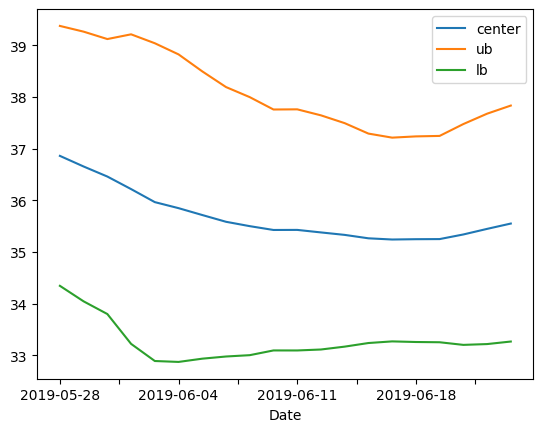

In [36]:
test_df.drop("Adj Close", axis = 1).plot()

In [39]:
start = "2011-01-02"
price_df2 = price_df.loc[start : ]
price_df2.head(2)

,Adj Close,center,ub,lb
Date,,,,
2011-01-03,29.295927,27.433909,29.236157,25.631661
2011-01-04,29.959959,27.569085,29.692262,25.445907


In [40]:
# 거래 내역이라는 파생변수
price_df2["trade"] = ""
price_df2.head(2)

C:\Users\duja1\AppData\Local\Temp\ipykernel_11696\4262563806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df2["trade"] = ""


,Adj Close,center,ub,lb,trade
Date,,,,,
2011-01-03,29.295927,27.433909,29.236157,25.631661,
2011-01-04,29.959959,27.569085,29.692262,25.445907,


### 구매내역
- 조건
    1. 상단 밴드보다 종가가 높은 경우
        - 현재 구매 상태이면
            - 매도 trade = ""
        - 구매 상태가 아니면
            - 아무 행동도 하지 않는다. trade = ""
    2. 하단 밴드보다 종가가 낮은 경우
        - 현재 구매 상태이면
            - 아무 행동도 하지않는다. trade = "buy"
        - 구매 상태가 아니면
            - 매수 trade = "buy"
    3. 하단 밴드와 상단 밴드 사이에 종가가 존재하는 경우
        - 현재 구매 상태이면
            - 아무 행동도 하지 않는다. trade = "buy"
        - 구매 상태가 아니면
            - 아무 행동도 하지 않는다. trade = ""

In [43]:
for i in price_df2.index :
    # 상단 밴드보다 종가가 높은 경우
    if price_df2.loc[i, "Adj Close"] > price_df2.loc[i, "ub"] :
        # 현재 구매 상태이면
        if price_df2.shift(1).loc[i, "trade"] == "buy" : 
            # 매도
            price_df2.loc[i, "trade"] = ""
        else :
            price_df2.loc[i, "trade"] = ""
    # 하단 밴드보다 종가가 낮은경우
    elif price_df2.loc[i, "Adj Close"] < price_df2.loc[i, "lb"] :
        # 현재 구매 상태이면
        if price_df2.shift(1).loc[i, "trade"] == "buy" :
            # 구매 상태를 유지
            price_df2.loc[i, "trade"] = "buy"
        else :
            price_df2.loc[i, "trade"] = "buy"
    else :
        # 현재 구매 상태이면
        if price_df2.shift(1).loc[i, "trade"] == "buy" :
            # 구매 상태를 유지
            price_df2.loc[i, "trade"] = "buy"
        else:
            price_df2.loc[i, "trade"] = ""

In [44]:
price_df2["trade"].value_counts()

buy    1130
       1002
Name: trade, dtype: int64

### 수익율 계산
1. 구매한 날의 종가
    - 전날의 trade 항목의 값이 ""이고, 현재의 trade가 "buy"인 날의 종가
2. 판매한 날의 종가
    - 전날의 trade 항목의 값이 "buy"이고, 현재의 trade가 ""인 날의 종가
3. 수익율 계산
    - (판매 가격 - 구매 가격) / 구매 가격 + 1
4. 구매 가격과 판매 가격을 초기화
5. 여러개의 수익율 발생
6. 여러개의 수익율로 누적 수익율 계산

In [45]:
rtn = 1.0
price_df2["return"] = 1
buy = 0.0
sell = 0.0

for i in price_df2.index :
    # 구매가를 출력
    if (price_df2.shift(1).loc[i, "trade"] == "") and \
        (price_df2.loc[i, "trade"] == "buy") :
        buy = price_df2.loc[i, "Adj Close"]
        print("진입일 :", i, "구매 가격 :", buy)
    # 판매가를 출력
    elif (price_df2.shift(1).loc[i, "trade"] == "buy") and \
        (price_df2.loc[i, "trade"] == "") :
        sell = price_df2.loc[i, "Adj Close"]
        rtn = (sell - buy) / buy + 1
        price_df2.loc[i, "return"] = rtn
        print("판매일 :", i, "판매 가격 :", sell, "수익율 :", rtn)
    # 구매가, 판매가를 초기화
    if price_df2.loc[i, "trade"] == "" :
        buy = 0.0
        sell = 0.0

C:\Users\duja1\AppData\Local\Temp\ipykernel_11696\1467481557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df2["return"] = 1


진입일 : 2011-02-02 구매 가격 : 28.205038
판매일 : 2011-04-05 판매 가격 : 25.983728 수익율 : 0.9212442117610337
진입일 : 2011-06-02 구매 가격 : 23.398802
판매일 : 2011-07-07 판매 가격 : 25.137901 수익율 : 1.0743242752342619
진입일 : 2011-07-27 구매 가격 : 22.244669
판매일 : 2012-01-05 판매 가격 : 17.525387 수익율 : 0.7878466072028314
진입일 : 2012-03-06 구매 가격 : 19.43049
판매일 : 2012-04-02 판매 가격 : 21.15378 수익율 : 1.0886899918633035
진입일 : 2012-04-09 구매 가격 : 19.1301
판매일 : 2012-08-07 판매 가격 : 16.142014 수익율 : 0.8438018619871303
진입일 : 2013-02-20 구매 가격 : 21.42255
판매일 : 2013-03-20 판매 가격 : 23.082602 수익율 : 1.0774908682673165
진입일 : 2013-06-20 구매 가격 : 25.738686
판매일 : 2013-09-10 판매 가격 : 29.248499 수익율 : 1.1363633326114626
진입일 : 2013-10-03 구매 가격 : 27.896749
판매일 : 2013-10-30 판매 가격 : 29.430317 수익율 : 1.0549730006173836
진입일 : 2014-01-16 구매 가격 : 30.8295
판매일 : 2014-03-05 판매 가격 : 29.659563 수익율 : 0.9620513793606772
진입일 : 2014-03-13 구매 가격 : 26.948151
판매일 : 2014-06-04 판매 가격 : 29.125372 수익율 : 1.080792964237138
진입일 : 2014-07-24 구매 가격 : 28.74103
판매일 : 2014-11-17 판매 가격 :

In [48]:
# 누적 수익율
acc_rtn = 1.0

for i in price_df2.index :
    rtn = price_df2.loc[i, "return"]
    acc_rtn *= rtn
    price_df2.loc[i, "acc_trn"] = acc_rtn

print("누적 수익율 :", acc_rtn)

누적 수익율 : 1.1764314536564138


C:\Users\duja1\AppData\Local\Temp\ipykernel_11696\2782148267.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df2.loc[i, "acc_trn"] = acc_rtn


In [49]:
price_df2.iloc[400 : 500]

,Adj Close,center,ub,lb,trade,return,acc_trn
Date,,,,,,,
2012-08-03,15.841622,15.463367,16.088070,14.838664,buy,1.000000,0.848899
2012-08-06,15.691425,15.448743,16.034625,14.862860,buy,1.000000,0.848899
2012-08-07,16.142014,15.473248,16.131447,14.815050,,0.843802,0.716303
2012-08-08,16.110388,15.492220,16.201580,14.782861,,1.000000,0.716303
2012-08-09,16.323826,15.544393,16.336778,14.752008,,1.000000,0.716303
...,...,...,...,...,...,...,...
2012-12-20,21.612268,20.131269,21.264959,18.997579,,1.000000,0.716303
2012-12-21,21.596457,20.214666,21.518225,18.911108,,1.000000,0.716303
2012-12-24,21.865231,20.310712,21.800205,18.821220,,1.000000,0.716303
